# Tekfors Prosjekt about video compression



The comments in the code will remain in English because my pappa says anyone who comments code in anything else should be fed to rabid dogs.

## Importer viktige ting vi trenger for koden

som inkluderer Numpy og Matplot 

- [NumPy homepage](https://numpy.org/)
- [Matplotlib homepage](https://matplotlib.org/)

In [38]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from PIL import Image
import time

Spesifisere filene som blir brukt

In [3]:
lowMotion = False

filename1 = ""
filename2 = ""

if lowMotion:
    filename1 = "small-out-001.jpg"
    filename2 = "small-out-002.jpg"
else:
    filename1 = "out464.jpg"
    filename2 = "out466.jpg"
    

Funksjon for å konvertere fra RGB fargeområde til Y (luminans), Cb og Cr (krominans for rød og blå)

[YCbCr Wikipedia](https://en.wikipedia.org/wiki/YCbCr#:~:text=YCbCr%2C%20Y%E2%80%B2CbCr%2C%20or,and%20red%2Ddifference%20chroma%20components.)

Dette er fordi video overføres med høyere betydning for 'rods'(som vi har mer av) enn 'cones'

[Photoreceptor Wikipedia](https://en.wikipedia.org/wiki/Photoreceptor_cell)

In [4]:
def rgb2ycbcr(im):
    transform = np.array(
        [
            #  Red     Green   Blue
            [ .299,    .587,  .114 ], # These make the Luma
            [-.1687, -.3313,  .5   ],   # These make the Blue differences (or Chroma Red)
            [ .5,    -.4187, -.0813] # These make the Red differences (or  Chroma Blue)
        ]
    )
    ycbcr = im.dot(transform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

Definer størrelsen av macroblockene vi vil bruke for motion searchen

In [5]:
blockWidth = 8
blockHeight = 8

Funksjon for å ekstrahere en 8x8 blokk/subimage fra et gitt kildebilde i den gitte området

In [6]:
def grabBlock(sourceImage, x, y):
    block = np.copy(
        sourceImage[
            y : y + blockHeight,
            x : x + blockWidth
        ])

    return block

Funksjon for å gjennomføre motion seach for valgt macroblock mellom en kilde og destinasjonsbilde

In [7]:
def searchBlock(img1, img2, blockAcross, blockDown, distanceRange):
    """Extracts a macroblock from img1 and searches img2 for the block with the lowest delta and returns the
        motion vector and delta.

        Parameters
        ----------
        img1 : ndarray
            The control image (width and height must be a multiple of blockWidth and blockHeight)

        img2 : ndarray
            The variable image (width and height must be a multiple of blockWidth and blockHeight)
            
        blockAcross : int
            The number of blocks from the left for the source
            
        blockDown : int
            The number of blocks from the top for the source
            
        distanceRange : int
            The number of pixels in any direction to search for an optimal delta
        """     
    
    # The pixel offset of the image
    blockLeft = blockAcross * blockWidth
    blockTop = blockDown * blockHeight    

    # This is the block from the destination image we're trying to duplicate as closely as possible by copying
    # a block from the previous image
    desiredBlock = grabBlock(img2, blockLeft, blockTop)

    # We arbitrarily choose a value we expect to be bigger than any delta is likely to be
    currentBest = 100000000
    
    # The motion vector of the best delta found so far. The default is "nothing changed yet"
    currentBestX = 0
    currentBestY = 0

    if (distanceRange == 0):
        # Get the block from the other image to compare to
        offsetBlock = grabBlock(img1, blockLeft, blockTop)

        # Find the difference between the first image block and the searched image block
        deltaImage = (desiredBlock.astype(int) - offsetBlock.astype(int))

        # Take the absolute value since a really big negative value will look better than a really small positive value
        absDeltaImage = np.abs(deltaImage)

        return np.sum(absDeltaImage), 0, 0
    
    # Clamp the search range values so that we never search past the left, top, right, or bottom of the images.
    minX = blockLeft - distanceRange
    if(minX < 0):
        minX = 0

    maxX = blockLeft + distanceRange
    if(maxX >= img1.shape[1] - blockWidth):
        maxX = img1.shape[1] - blockWidth - 1

    minY = blockTop - distanceRange
    if(minY < 0):
        minY = 0

    maxY = blockTop + distanceRange
    if(maxY >= img1.shape[0] - blockHeight):
        maxY = img1.shape[0] - blockHeight - 1

    # Try each position one by one in a grid specified by the clamped values
    for offsetY in range(minY,maxY+1):
        for offsetX in range(minX, maxX+1):
                        
            # Get the block from the other image to compare to
            offsetBlock = grabBlock(img1, offsetX, offsetY)
            
            # Find the difference between the first image block and the searched image block
            deltaImage = (desiredBlock.astype(int) - offsetBlock.astype(int))
            
            # Take the absolute value since a really big negative value will look better than a really small positive value
            absDeltaImage = np.abs(deltaImage)
            
            # Aggregate the values
            absSum = np.sum(absDeltaImage)

            # If this delta is less than the previously best delta, then update the findings
            if (absSum < currentBest):
                currentBestX = offsetX - blockLeft
                currentBestY = offsetY - blockTop
                currentBest = absSum

    # Return X,Y, and T for the best delta
    return currentBest, currentBestX, currentBestY
    

Les det første bildet, konverter det til luminanseverdier og lag et tilsvarende grayscale bilde

Også crop imput bildet til den nærmeste 8-ende ganger'n

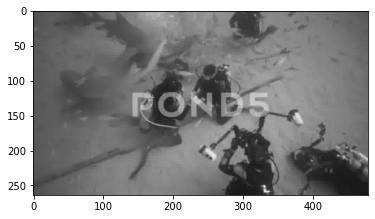

In [27]:
# Read the first image
image1 = Image.open(filename1)

# If the image is too big to plot as a relief map, make it smaller
if (image1.size[0] >= 480):
    newWidth = int(480)
    newHeight = int(image1.size[1] * 480 / image1.size[0])
    
    image1 = image1.resize((newWidth, newHeight))
    
rawImage1 = np.asarray(image1)

# Nasty bit-twiddling hack to round (down) the image width and height to the nearest 8 pixels
imageWidth = rawImage1.shape[1] & ~7
imageHeight = rawImage1.shape[0] & ~7

# Convert the first image to yCbCr and extract the luma values as a numerical array
yCbCrImage=rgb2ycbcr(rawImage1[0:imageHeight,0:imageWidth,0:3])
luma1 = yCbCrImage[:,:,0]

# Reassemble the luminance to a grayscale image which simply plugs the luma values into R,G, and B
grayImage1 = np.zeros_like(yCbCrImage)
grayImage1[:,:,0] = luma1
grayImage1[:,:,1] = luma1
grayImage1[:,:,2] = luma1

vals = luma1
val_xdim, val_ydim = vals.shape

plt.imshow(grayImage1)
plt.show()

Gjør det samme for det andre bildet i sekvensen

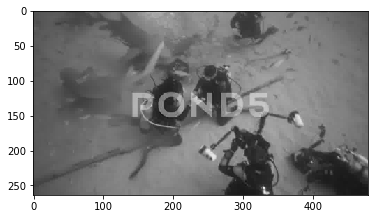

In [28]:
# Read the second image
image2 = Image.open(filename2)

# If the image is too big to plot as a relief map, make it smaller
if (image2.size[0] >= 480):
    newWidth = int(480)
    newHeight = int(image2.size[1] * 480 / image2.size[0])
    
    image2 = image2.resize((newWidth, newHeight))
    
rawImage2 = np.asarray(image2)

# Convert the second image to yCbCr and extract the luma values as a numerical array
yCbCrImage=rgb2ycbcr(rawImage2[0:imageHeight,0:imageWidth,0:3])
luma2 = yCbCrImage[:,:,0]

# Reassemble the luminance to a grayscale image which simply plugs the luma values into R,G, and B
grayImage2 = np.zeros_like(yCbCrImage)
grayImage2[:,:,0] = luma2
grayImage2[:,:,1] = luma2
grayImage2[:,:,2] = luma2

plt.imshow(grayImage2, interpolation='nearest')
plt.show()

In [29]:
def frameMotionSearch(img1, img2, searchDepth):
    # Track the total delta for the search range
    totalDelta = 0

    # Calculate the number of blocks to search
    wide = int(rawImage1.shape[1] / blockWidth);
    high = int(rawImage1.shape[0] / blockHeight);

    # Create arrays to store results about motion vectors and their locations filled with zeros
    px = np.zeros((wide, high))
    py = np.zeros((wide, high))
    mvx = np.zeros((wide, high))
    mvy = np.zeros((wide, high))

    # For each block in each column and in each row calculate the motion vectors
    for a in range(0,wide):
        for d in range(0,high):
            # Get the delta and the motion vector for the given search
            delta, motionX, motionY = searchBlock(img1, img2, a, d, rng) 

            # Add the delta to the overall sum
            totalDelta += delta

            # Store information for plotting the vector map
            px[a, d] = a
            py[a, d] = d
            mvx[a, d] = motionX 
            mvy[a, d] = motionY 
            
    return totalDelta, px, py, mvx, mvy

Gjennomfør mottion seachen mellom de to framesene og lagre beregninger om informasjonen funnet

In [30]:
# Specify the search range to be up to the given value
rng = 7

totalDelta, px, py, mvx, mvy = frameMotionSearch(luma1, luma2, rng)

print(f"Total aggregate in a search area of {rng} is {totalDelta}")

Total aggregate in a search area of 7 is 285714


Lag et nytt bilde bare fra det første bildet og de beregnede motion vectorene

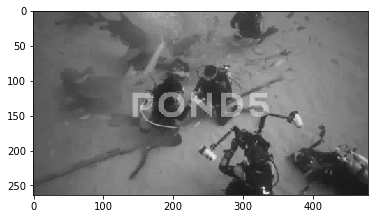

In [31]:
# Make a new image with nothing but zeros in it
reassembledLuma = np.zeros_like(luma1)

# Calculate the number of blocks to search
wide = int(rawImage1.shape[1] / blockWidth);
high = int(rawImage1.shape[0] / blockHeight);

# Now for each block in the image, let's use the deltas to grab the right image from the source
for a in range(0,wide):
    for d in range(0,high):

        currentX = a * blockWidth
        currentY = d * blockHeight
        
        moveX = mvx[a,d]
        moveY = mvy[a,d]
        motionX = currentX + mvx[a, d]
        motionY = currentY + mvy[a, d]
        block = grabBlock(luma1, int(motionX), int(motionY))
        
        # Gonna look for that copy function now
        reassembledLuma[currentY:currentY + block.shape[1], currentX:currentX + block.shape[0]] = block
                
        
reassembledImage = np.zeros_like(yCbCrImage)
reassembledImage[:,:,0] = reassembledLuma
reassembledImage[:,:,1] = reassembledLuma
reassembledImage[:,:,2] = reassembledLuma

plotReassembledImage = Image.fromarray(reassembledImage)

plt.imshow(plotReassembledImage, interpolation='nearest')
plt.show()

Lag en array som viser oppsetningen av dektaen mellom de orginale 2 bildene

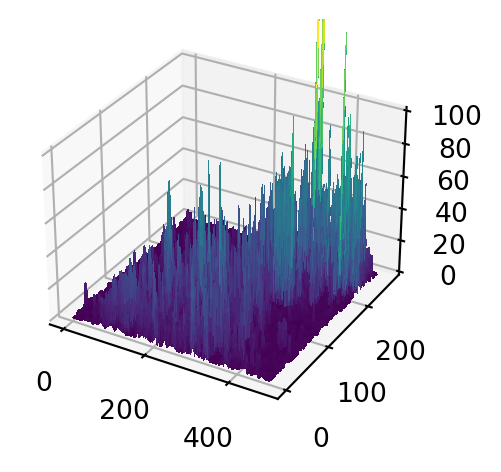

In [32]:
differenceLuma2Luma1 = np.abs(luma2.astype(int) - luma1.astype(int))

# Define the values in terms which can be plotted as an relief map
vals = differenceLuma2Luma1
val_xdim, val_ydim = vals.shape

# generate meshgrid for plot
xax = np.arange(0, val_xdim)
yax = np.arange(0, val_ydim)
xax, yax = np.meshgrid(yax, xax)

fig = plt.figure()
fig.set_dpi(192)

ax = fig.add_subplot(1, 2, 1,  projection='3d')
surf = ax.plot_surface(xax, yax, vals, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_zlim(0, 100)

plt.show()

Nå lag et relief map mellom det andre bildet og det bilde som var lagd fra det første med deltaene lagt til

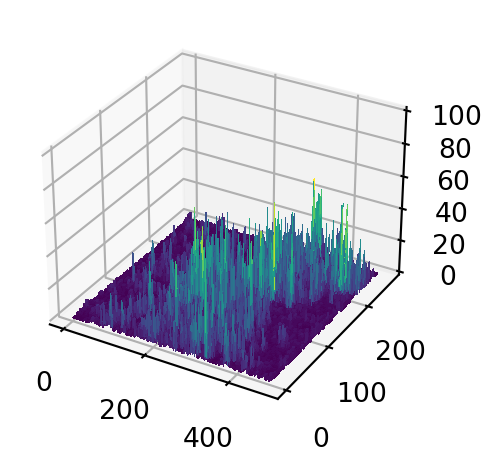

In [33]:
differenceLuma2Reassembled = np.abs(luma2.astype(int) - reassembledLuma.astype(int))

vals4 = differenceLuma2Reassembled
val4_xdim, val4_ydim = vals4.shape

# generate meshgrid for plot
xax4 = np.arange(0, val4_xdim)
yax4 = np.arange(0, val4_ydim)
xax4, yax4 = np.meshgrid(yax4, xax4)

fig = plt.figure()
fig.set_dpi(192)

ax = fig.add_subplot(1, 2, 1,  projection='3d')
surf = ax.plot_surface(xax4, yax4, vals4, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax.set_zlim(0, 100)

plt.show()

Plott bare deltaene

På venstre siden plasser pixel deltaene mellom framesene

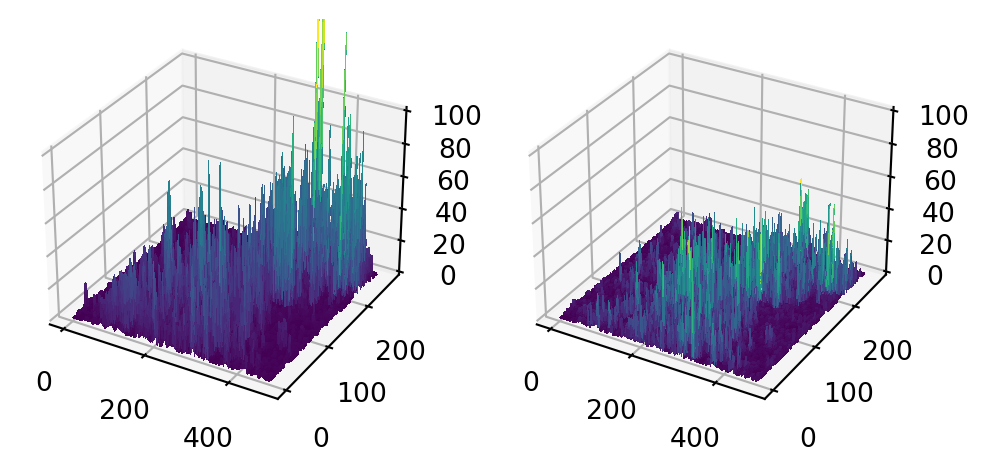

In [35]:
fig = plt.figure()
fig.set_dpi(192)

ax5 = fig.add_subplot(1, 2, 1,  projection='3d')
surf = ax5.plot_surface(xax, yax, vals, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax5.set_zlim(0, 100)

ax6 = fig.add_subplot(1, 2, 2,  projection='3d')
surf = ax6.plot_surface(xax4, yax4, vals4, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
ax6.set_zlim(0, 100)

plt.show()


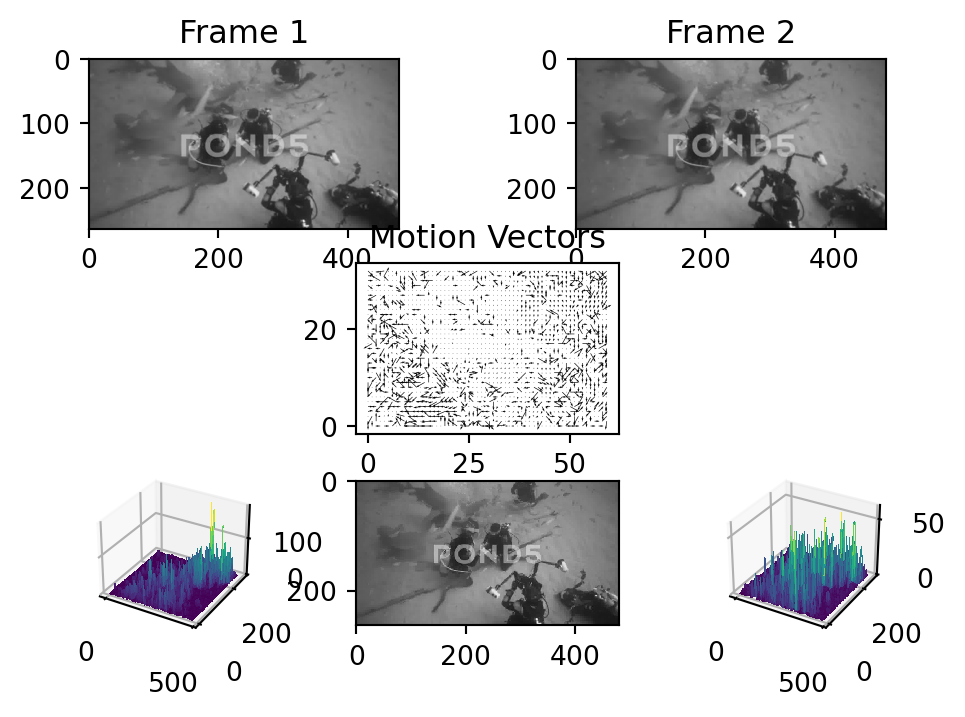

In [36]:
fig = plt.figure()
fig.set_dpi(192)

ax2 = fig.add_subplot(3,2,1)
ax2.imshow(grayImage1)
ax2.set_title('Frame 1')

ax3 = fig.add_subplot(3,2,2)
ax3.imshow(grayImage2)
ax3.set_title('Frame 2')

ax1 = fig.add_subplot(3,3,5)
ax1.quiver(px, py, mvx, mvy)
ax1.set_title('Motion Vectors')

ax4 = fig.add_subplot(3, 3, 8)
ax4.imshow(plotReassembledImage, interpolation='nearest')

plot3d = True

if plot3d:
    ax5 = fig.add_subplot(3, 3, 7,  projection='3d')
    surf = ax5.plot_surface(xax, yax, vals, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)

    ax6 = fig.add_subplot(3, 3, 9,  projection='3d')
    surf = ax6.plot_surface(xax4, yax4, vals4, rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)


Generer en rapport som viser resultatene mellom forskjellige søkningsdybder/ranges

In [39]:
# Specify the search range to be up to the given value

for rng in range(0,20):
    st = time.process_time()
    totalDelta, px, py, mvx, mvy = frameMotionSearch(luma1, luma2, rng)
    et = time.process_time()
    
    print(f"Total aggregate in a search area of {rng} is {totalDelta} - time {et - st}")

Total aggregate in a search area of 0 is 532649 - time 0.032864041000038924
Total aggregate in a search area of 1 is 386287 - time 0.19773357499997246
Total aggregate in a search area of 2 is 332857 - time 0.4853453239999794
Total aggregate in a search area of 3 is 308477 - time 0.9496919779999757
Total aggregate in a search area of 4 is 291573 - time 1.539184793000004
Total aggregate in a search area of 5 is 289476 - time 2.2790927279999664
Total aggregate in a search area of 6 is 287715 - time 3.2502051129999927
Total aggregate in a search area of 7 is 285714 - time 4.183318299000007
Total aggregate in a search area of 8 is 281084 - time 5.261291411999991
Total aggregate in a search area of 9 is 280508 - time 6.918570127999999
Total aggregate in a search area of 10 is 279917 - time 8.09763398199999
Total aggregate in a search area of 11 is 278869 - time 10.310366019000014
Total aggregate in a search area of 12 is 276104 - time 11.580057262999958
Total aggregate in a search area of 13